In [1]:
#Import Packages
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import xarray as xr
import pytz
import os
import datetime
import sys
sys.path.append('..')
import funcs.ac_funcs as ac

pd.options.mode.chained_assignment = None

%load_ext autoreload
%autoreload 2


# TCCON Met Data Extraction

In [ ]:
tccon_data_fullpath = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/TCCON/ci20230502_20230701.private.nc'
f = netCDF4.Dataset(tccon_data_fullpath)

#Unit,UTCDate,UTCTime,WSPD,WDIR,SigTheta,Gust,Tout,RH,Pout,Sflux,Precip,LeafWet,Battery,Bit
# format the time 
time = f.variables['time']
datetimes = netCDF4.num2date(time[:], time.units)
datetimes = [date.strftime('%Y-%m-%d %H:%M:%S') for date in datetimes]

# list the variables you want to keep
cols = list( ['tout','pout','hout','wspd','wdir'] )

# extract those variables from the netcdf and append together
list_nc = []
for c in cols:
    list_nc.append(list(f.variables[c][:]))
    
# convert into pandas dataframe
df = pd.DataFrame(list_nc)
df = df.T # transpose the dataframe
df.columns = cols # set column names

# add the time as the dataframe index 
df['dt'] = pd.to_datetime(datetimes, utc = True)
df = df.rename(columns = {'tout':'Tout','pout':'Pout','wspd':'WSPD','wdir':'WDIR','hout':'RH'})
df['UTCDate'] = df.apply(lambda row: datetime.datetime.strftime(row['dt'],'%y/%m/%d'),axis = 1)
df['UTCTime'] = df.apply(lambda row: datetime.datetime.strftime(row['dt'],'%H:%M:%S'),axis = 1)
# subset the time period of interest 
sub_df = df.loc[(df['UTCDate']=='23/05/16')]
sub_df = sub_df[['UTCDate','UTCTime','Tout','Pout','RH','WSPD','WDIR']]

In [ ]:
met_save_path = '/uufs/chpc.utah.edu/common/home/lin-group15/agm/em27/ua/inst_data/met/tccon/'
dates = ['2023-05-16','2023-05-17','2023-05-18','2023-05-19']
sub_dfs = {}
for date in dates:
    sub_df = df.loc[(df['dt']>=f'{date} 00:00:00')&(df['dt']<=f'{date} 23:59:59')]
    sub_df = sub_df[['UTCDate','UTCTime','Tout','Pout','RH','WSPD','WDIR']]
    filename = f"{date.replace('-','')}_tccon.txt"
    fullsavepath = os.path.join(met_save_path,filename)
    sub_df.to_csv(fullsavepath,index=False)

# Caltech met data

Data taken from http://tccon-weather.caltech.edu/. This merges the individual datasets (pressure, temp, etc) into a form readable by EGI

In [38]:
# separate_caltech_weather_path = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/met/caltech' 
# met_save_path = '/uufs/chpc.utah.edu/common/home/lin-group15/agm/em27/ua/inst_data/met/caltech/'

# dates = ['2023-05-16','2023-05-17','2023-05-18','2023-05-19']
# for date in dates:
#     dfs = []
#     for file in sorted(os.listdir(separate_caltech_weather_path)):
#         if file.startswith(date):
#             df = pd.read_csv(os.path.join(separate_caltech_weather_path,file))
#             df['dt'] = pd.to_datetime(df['Time'])
#             df = df.set_index('dt')
#             df = df.drop('Time',axis = 1)
#             dfs.append(df)# = pd.concat([date_df,df])
#     date_df = pd.concat(dfs,axis = 1)
#     date_df = date_df.resample('1T').mean().interpolate(method='linear')
#     date_df = date_df.rename(columns = {'Relative Humidity (%)':'RH','Pressure (mb)':'Pout','Temperature (&deg;C)':'Tout'})
#     date_df['UTCDate'] = date_df.index.strftime('%y/%m/%d')
#     date_df['UTCTime'] = date_df.index.strftime('%H:%M:%S')
#     date_df = date_df.reset_index(drop=True)[['UTCDate','UTCTime','Tout','Pout','RH']]
#     save_name = f"{date.replace('-','')}_caltech.txt"
#     date_df.to_csv(os.path.join(met_save_path,save_name),index=False)


# TCCON/EM27 Comparison

In [2]:
#Load the EM27 Data
em27_data_folder = "/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/EM27_oof/summer_2023/elaine_retrievals/ua/"

dt1_str = '2023-05-16 00:00:00'
dt2_str =  '2023-05-19 10:00:00'
tz = 'UTC'

oof_manage = ac.oof_manager(em27_data_folder,tz)
em27_df = oof_manage.load_oof_df_inrange(dt1_str,dt2_str,True)

em27_df_sub = em27_df[['xch4(ppm)','xch4(ppm)_error','xco2(ppm)','xco2(ppm)_error','xco(ppb)','xco(ppb)_error','xluft','xluft_error']]
for col in em27_df_sub.columns:
    new_col_name = col.replace('(ppm)','')
    new_col_name = new_col_name.replace('(ppb)','')
    new_col_name = new_col_name+'_em27'
    em27_df_sub = em27_df_sub.rename(columns={col:new_col_name})

## Load the TCCON data into a dataframe

# Point to the TCCON netcdf we want to read
tccon_data_fullpath = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/TCCON/ci20230502_20230701.private.nc'
f = netCDF4.Dataset(tccon_data_fullpath)

# format the time 
time = f.variables['time']
datetimes = netCDF4.num2date(time[:], time.units)
datetimes = [date.strftime('%Y-%m-%d %H:%M:%S') for date in datetimes]

# list the variables you want to keep
cols = ['lat', 'long','xco2','xco2_error','xco','xco_error','xch4','xch4_error','xluft','xluft_error']

# extract those variables from the netcdf and append together
list_nc = []
for c in cols:
    list_nc.append(list(f.variables[c][:]))
    
# convert into pandas dataframe
tccon_df = pd.DataFrame(list_nc)
tccon_df = tccon_df.T # transpose the dataframe
tccon_df.columns = cols # set column names

# add the time as the dataframe index 
tccon_df.index = pd.to_datetime(datetimes, utc = True)

#trim the tccon df to the range of data in the em27 df
tccon_df_sub = tccon_df.loc[(tccon_df.index>=min(em27_df.index))&(tccon_df.index<=max(em27_df.index))]
tccon_df_sub = tccon_df_sub[['xch4','xch4_error','xco2','xco2_error','xco','xco_error','xluft','xluft_error']]
for col in tccon_df_sub.columns:
    new_col_name = col+'_tccon'
    tccon_df_sub = tccon_df_sub.rename(columns={col:new_col_name})

In [3]:
resample_interval = '10T'
clip_range = ['2023-05-16 20:00:00','2023-05-19 00:00:00']
em27_df_resampled = em27_df_sub.resample(resample_interval).mean(numeric_only=True)
tccon_df_resampled = tccon_df_sub.resample(resample_interval).mean(numeric_only=True)
merged_df = pd.concat([em27_df_resampled,tccon_df_resampled],axis = 1)
merged_df = merged_df.loc[(merged_df.index>=clip_range[0])&(merged_df.index<=clip_range[1])]
merged_df = merged_df.dropna()

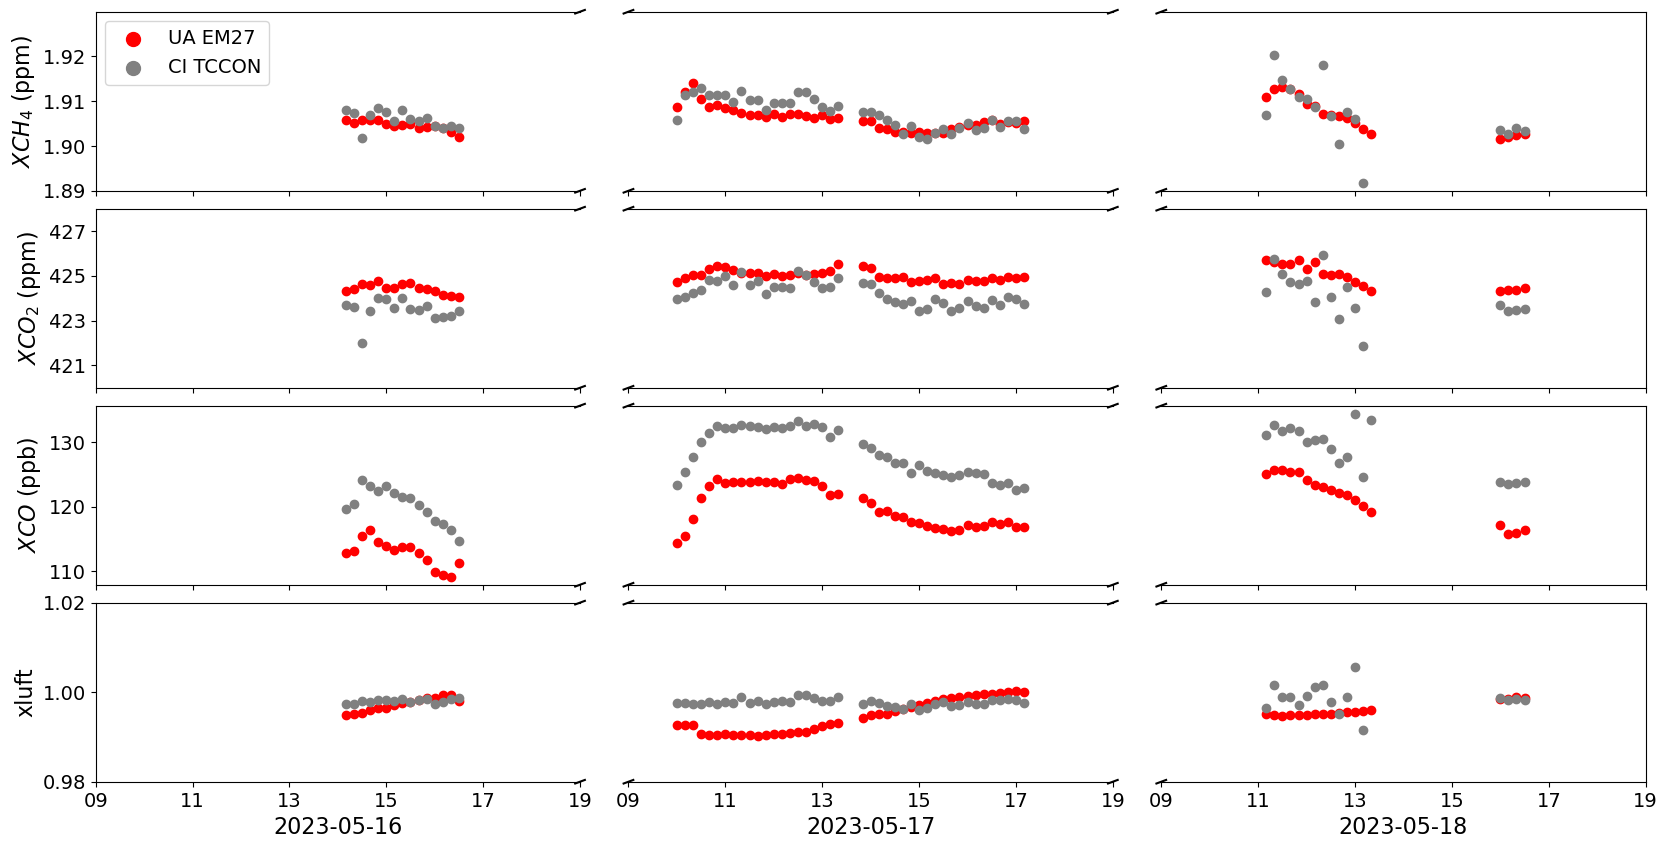

In [4]:
broken_dtranges = [[pd.to_datetime('2023-05-16 08:00:00').tz_localize('US/Pacific'),pd.to_datetime('2023-05-16 18:00:00').tz_localize('US/Pacific')],
                   [pd.to_datetime('2023-05-17 08:00:00').tz_localize('US/Pacific'),pd.to_datetime('2023-05-17 18:00:00').tz_localize('US/Pacific')],
                   [pd.to_datetime('2023-05-18 08:00:00').tz_localize('US/Pacific'),pd.to_datetime('2023-05-18 18:00:00').tz_localize('US/Pacific')]]


fig,axes = plt.subplots(4,len(broken_dtranges),figsize = (20,10))
labsize = 16
d= 0.01
plot_df = merged_df.copy()
plot_df.index = plot_df.index.tz_convert('US/Pacific')


row = 0
for col in range(len(broken_dtranges)):
    axes[row][col].scatter(plot_df.index,plot_df[f'xch4_em27'],color = 'red')
    axes[row][col].scatter(plot_df.index,plot_df[f'xch4_tccon'],color = 'grey')
    if col <len(broken_dtranges)-1:
        axes[row][col].spines['right'].set_visible(False)
        axes[row][col].yaxis.tick_left()
    if col > 0:
        axes[row][col].yaxis.set_visible(False)
    axes[row][col].set_ylim([1.89,1.93])
    if col>0:
        axes[row][col].spines['left'].set_visible(False)
        axes[row][col].yaxis.tick_right()
    if col<len(broken_dtranges)-1:
        kwargs = dict(transform=axes[0][col].transAxes, color='k', clip_on=False)
        axes[row][col].plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
        axes[row][col].plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal
    if col>0:
        kwargs.update(transform=axes[0][col].transAxes) # switch to the bottom axes
        axes[row][col].plot((-d,d),(-d,+d), **kwargs) # top-right diagonal
        axes[row][col].plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal
    axes[row][col].set_yticks([1.89,1.90,1.91,1.92]) 
    axes[row][col].get_xaxis().set_ticklabels([])
    axes[row][col].xaxis.set_major_locator(mdates.HourLocator(interval=2))
    axes[row][col].set_xlim(broken_dtranges[col][0],broken_dtranges[col][1])
axes[row][0].set_ylabel('$XCH_4$ (ppm)',size = labsize)
axes[row][0].tick_params(labelsize = labsize-2)

row = 1
for col in range(len(broken_dtranges)):
    axes[row][col].scatter(plot_df.index,plot_df[f'xco2_em27'],color = 'red')
    axes[row][col].scatter(plot_df.index,plot_df[f'xco2_tccon'],color = 'grey')
    axes[row][col].set_xlim(broken_dtranges[col][0],broken_dtranges[col][1])

    if col <len(broken_dtranges)-1:
        axes[row][col].spines['right'].set_visible(False)
        axes[row][col].yaxis.tick_left()
    if col > 0:
        axes[row][col].yaxis.set_visible(False)
    axes[row][col].set_ylim([420,428])
    if col>0:
        axes[row][col].spines['left'].set_visible(False)
        axes[row][col].yaxis.tick_right()
    if col<len(broken_dtranges)-1:
        kwargs = dict(transform=axes[row][col].transAxes, color='k', clip_on=False)
        axes[row][col].plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
        axes[row][col].plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal
    if col>0:
        kwargs.update(transform=axes[row][col].transAxes) # switch to the bottom axes
        axes[row][col].plot((-d,d),(-d,+d), **kwargs) # top-right diagonal
        axes[row][col].plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal
    axes[row][col].set_yticks([421,423,425,427]) 
    axes[row][col].get_xaxis().set_ticklabels([])
    axes[row][col].xaxis.set_major_locator(mdates.HourLocator(interval=2))
axes[row][0].set_ylabel('$XCO_2$ (ppm)',size = labsize)
axes[row][0].tick_params(labelsize = labsize-2)

row = 2
for col in range(len(broken_dtranges)):
    axes[row][col].scatter(plot_df.index,plot_df[f'xco_em27'],color = 'red')
    axes[row][col].scatter(plot_df.index,plot_df[f'xco_tccon'],color = 'grey')
    if col <len(broken_dtranges)-1:
        axes[row][col].spines['right'].set_visible(False)
        axes[row][col].yaxis.tick_left()
    if col > 0:
        axes[row][col].yaxis.set_visible(False)
    #axes[row][col].set_ylim([420,428])
    if col>0:
        axes[row][col].spines['left'].set_visible(False)
        axes[row][col].yaxis.tick_right()
    if col<len(broken_dtranges)-1:
        kwargs = dict(transform=axes[row][col].transAxes, color='k', clip_on=False)
        axes[row][col].plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
        axes[row][col].plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal
    if col>0:
        kwargs.update(transform=axes[row][col].transAxes) # switch to the bottom axes
        axes[row][col].plot((-d,d),(-d,+d), **kwargs) # top-right diagonal
        axes[row][col].plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal
    #axes[row][col].set_yticks([421,423,425,427]) 
    axes[row][col].get_xaxis().set_ticklabels([])
    axes[row][col].xaxis.set_major_locator(mdates.HourLocator(interval=2))
    axes[row][col].set_xlim(broken_dtranges[col][0],broken_dtranges[col][1])
axes[row][0].set_ylabel('$XCO$ (ppb)',size = labsize)
axes[row][0].tick_params(labelsize = labsize-2)

row = 3
for col in range(len(broken_dtranges)):
    axes[row][col].scatter(plot_df.index,plot_df[f'xluft_em27'],color = 'red')
    axes[row][col].scatter(plot_df.index,plot_df[f'xluft_tccon'],color = 'grey')
    if col <len(broken_dtranges)-1:
        axes[row][col].spines['right'].set_visible(False)
        axes[row][col].yaxis.tick_left()
    if col > 0:
        axes[row][col].yaxis.set_visible(False)
    axes[row][col].set_ylim([0.98,1.02])
    if col>0:
        axes[row][col].spines['left'].set_visible(False)
        axes[row][col].yaxis.tick_right()
    if col<len(broken_dtranges)-1:
        kwargs = dict(transform=axes[row][col].transAxes, color='k', clip_on=False)
        axes[row][col].plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
        axes[row][col].plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal
    if col>0:
        kwargs.update(transform=axes[row][col].transAxes) # switch to the bottom axes
        axes[row][col].plot((-d,d),(-d,+d), **kwargs) # top-right diagonal
        axes[row][col].plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal
    #axes[row][col].set_yticks([421,423,425,427]) 
    axes[row][col].get_xaxis().set_ticklabels([])
    axes[row][col].xaxis.set_major_locator(mdates.HourLocator(interval=2))
    axes[row][col].set_xlim(broken_dtranges[col][0],broken_dtranges[col][1])
axes[row][0].set_ylabel('xluft',size = labsize)
axes[row][0].tick_params(labelsize = labsize-2)

axes[0][0].scatter([],[],color = 'red',label = 'UA EM27',s = 100)
axes[0][0].scatter([],[],color = 'grey',label = 'CI TCCON',s = 100)

axes[0][0].legend(fontsize = labsize-2,loc = 2)

for col in range(len(broken_dtranges)):
    axes[-1][col].tick_params(labelsize = labsize-2)
    axes[-1][col].xaxis.set_major_locator(mdates.HourLocator(interval=2))   
    axes[-1][col].xaxis.set_major_formatter(mdates.DateFormatter('%H',tz='US/Mountain'))
    axes[-1][col].set_xlabel(broken_dtranges[col][0].strftime('%Y-%m-%d'),size =labsize)

plt.subplots_adjust(hspace=0.1,wspace = 0.1)
plt.show()

In [5]:
specs = ['xch4','xco2','xco','xluft']
tccon_ua_diff_dict = {}
for spec in specs:
    merged_df[f'{spec}_diff'] = merged_df.apply(lambda row: row[f'{spec}_tccon']-row[f'{spec}_em27'],axis = 1)
    tccon_ua_diff_dict[spec] = dict(merged_df[f'{spec}_diff'].describe())
tccon_ua_diff_dict

{'xch4': {'count': 75.0,
  'mean': 0.002423698609672682,
  'std': 0.012280470890963922,
  'min': -0.012109092087581264,
  '25%': -0.00010854968624340877,
  '50%': 0.0014531283727505784,
  '75%': 0.0024946397729567193,
  'max': 0.10442496948242197},
 'xco2': {'count': 75.0,
  'mean': -0.5685790046311839,
  'std': 2.490528905558594,
  'min': -2.694020954000564,
  '25%': -1.0714125976562627,
  '50%': -0.835439422984166,
  '75%': -0.6018618701599507,
  'max': 20.258756103515623},
 'xco': {'count': 75.0,
  'mean': 7.876710989967739,
  'std': 1.5845583798819727,
  'min': 3.392286194918455,
  '25%': 6.978228494883616,
  '50%': 8.217048023365166,
  '75%': 8.537231456477464,
  'max': 14.173743896484382},
 'xluft': {'count': 75.0,
  'mean': 0.003169949152000517,
  'std': 0.006426685964116104,
  'min': -0.004321825093236531,
  '25%': -0.0004436561182925569,
  '50%': 0.002169104998788751,
  '75%': 0.006225577877555122,
  'max': 0.04910624027252197}}